In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import gymnasium as gym
import gym_trading_env

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from RLTrade.agent import DQNAgent, XGBoostAgent
from RLTrade.utils import (
    stationaryDGP, 
    nonstationaryDGP, 
    build_features, 
    build_rolling_feature,
)

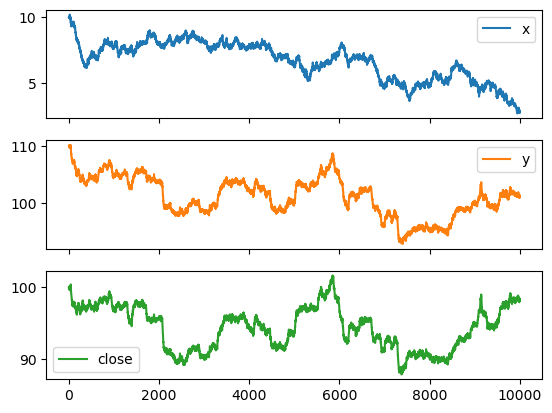

In [2]:
x, y = nonstationaryDGP()
spread = y - x
df = pd.DataFrame({'x': x, 'y': y, 'close': spread}) # close price of portfolio is the spread
df.plot(subplots=True)
plt.show()

In [3]:
# confirm the x, y pair is not cointegrated
x_ols = sm.add_constant(x)
ols = sm.OLS(y, x_ols).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     3512.
Date:                Wed, 05 Jun 2024   Prob (F-statistic):               0.00
Time:                        22:05:55   Log-Likelihood:                -25018.
No. Observations:               10000   AIC:                         5.004e+04
Df Residuals:                    9998   BIC:                         5.005e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         93.0271      0.139    669.388      0.0

In [4]:
adfuller_test = adfuller(spread)
print(f'ADF Statistic: {adfuller_test[0]}')
print(f'p-value: {adfuller_test[1]}')
print('Is the spread stationary? {}'.format('Yes' if adfuller_test[1] < 0.05 else 'No'))

ADF Statistic: -2.271213554528729
p-value: 0.18142028797377674
Is the spread stationary? No


In [5]:
# build features
df_train = df.copy()

feature_config = {
    "feature_col": "close",
    "window": 7, # 7 days window, pad with first value when window is not available
    "mode": "diff", # difference between current and previous close price
    "mean_correction": True,
}

df_train = build_rolling_feature(df_train, **feature_config)
df_train

,x,y,close,feature_rolling_0,feature_rolling_1,feature_rolling_2,feature_rolling_3,feature_rolling_4,feature_rolling_5,feature_rolling_6
0,10.000177,109.924943,99.924766,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,9.957001,109.929686,99.972684,0.041073,-0.006846,-0.006846,-0.006846,-0.006846,-0.006846,-0.006846
2,9.894291,109.968013,100.073721,0.079758,0.026639,-0.021279,-0.021279,-0.021279,-0.021279,-0.021279
3,9.823106,109.981362,100.158256,0.051178,0.067681,0.014563,-0.033356,-0.033356,-0.033356,-0.033356
4,9.886745,109.989408,100.102662,-0.081007,0.059120,0.075623,0.022505,-0.025414,-0.025414,-0.025414
...,...,...,...,...,...,...,...,...,...,...
9995,13.199379,123.071746,109.872367,-0.143260,0.116301,-0.114766,-0.049662,-0.114503,0.059693,0.246197
9996,13.347557,123.272481,109.924924,0.083777,-0.116190,0.143371,-0.087696,-0.022592,-0.087433,0.086763
9997,13.282487,123.073356,109.790869,-0.075749,0.110862,-0.089105,0.170456,-0.060611,0.004493,-0.060347
9998,13.189703,122.974189,109.784486,0.035884,-0.091787,0.094824,-0.105143,0.154418,-0.076649,-0.011546


In [6]:
# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationaryDGP",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)
while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(0) # always short position

n_actions = env.action_space.n
n_observations = len(env.reset()[0])

[ 0.  0.  0.  0.  0.  0.  0. -1. -1.]
Market Return :  9.83%   |   Portfolio Return : -9.83%   |   Position Changes : 0   |   Episode Length : 10000   |   


In [7]:
# Train a DQN agent using training data from a stationary data generating process
agent = DQNAgent(n_observations=n_observations, n_actions=n_actions)
history_metrics, _ = agent.train(env, num_episodes=15) # Beware of overfitting when num_episodes is too high

Market Return :  8.36%   |   Portfolio Return : -49.22%   |   Position Changes : 5721   |   Episode Length : 10000   |   
Market Return :  8.36%   |   Portfolio Return : -30.73%   |   Position Changes : 4801   |   Episode Length : 10000   |   
Market Return :  8.36%   |   Portfolio Return : -30.18%   |   Position Changes : 4718   |   Episode Length : 10000   |   
Market Return :  8.36%   |   Portfolio Return : -32.72%   |   Position Changes : 4656   |   Episode Length : 10000   |   
Market Return :  8.36%   |   Portfolio Return : -18.37%   |   Position Changes : 4626   |   Episode Length : 10000   |   
Market Return :  8.36%   |   Portfolio Return : -25.69%   |   Position Changes : 4532   |   Episode Length : 10000   |   
Market Return :  8.36%   |   Portfolio Return : -17.34%   |   Position Changes : 4502   |   Episode Length : 10000   |   
Market Return :  8.36%   |   Portfolio Return : -14.49%   |   Position Changes : 4472   |   Episode Length : 10000   |   
Market Return :  8.36%  

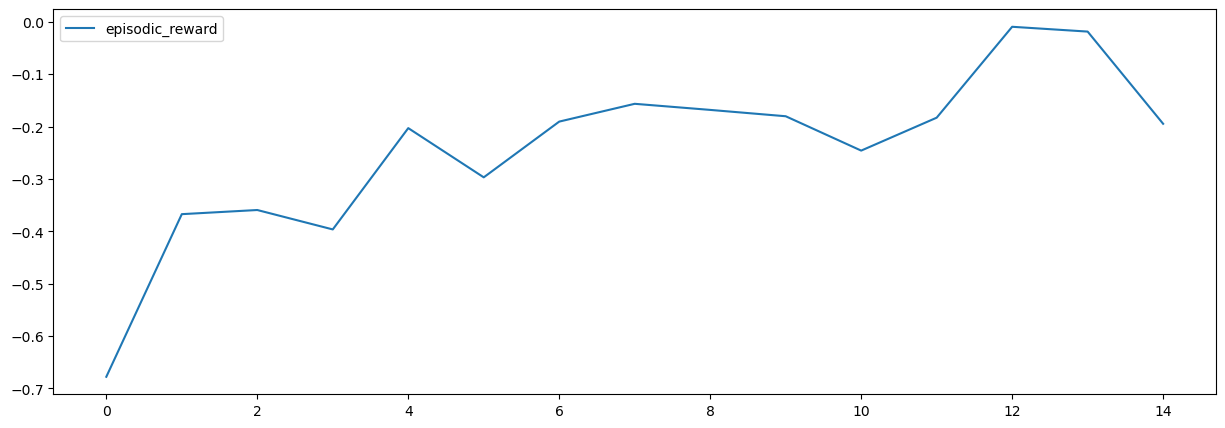

In [8]:
all_metrics = pd.DataFrame(history_metrics)
perc2float = lambda x: float(x.strip('%'))/100

all_metrics["Market Return"] = all_metrics["Market Return"].apply(perc2float)
all_metrics["Portfolio Return"] = all_metrics["Portfolio Return"].apply(perc2float)

all_metrics.plot(y=["episodic_reward"], figsize=(15, 5))
plt.show()

In [10]:
# Evaluate the agent on a new dataset from the same data generating process
returns = []
for i in range(10):
    x, y = nonstationaryDGP()
    spread = y - x
    _df = pd.DataFrame({'x': x, 'y': y, 'close': spread})
    _df = build_rolling_feature(_df, **feature_config)
    
    env_test = gym.make("TradingEnv",
            name= "stationaryDGP",
            df = _df, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        )
    env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    env_test = agent.eval(env_test)
    returns.append(perc2float(env_test.unwrapped.get_metrics()["Portfolio Return"]))

print(f"Average Portfolio Return: {np.mean(returns)}")
print(f"Std Portfolio Return: {np.std(returns)}")

Market Return : -87.45%   |   Portfolio Return : -39.19%   |   Position Changes : 5759   |   Episode Length : 10000   |   
Market Return : -17.94%   |   Portfolio Return : -57.46%   |   Position Changes : 6557   |   Episode Length : 10000   |   
Market Return : -11.21%   |   Portfolio Return : -56.99%   |   Position Changes : 6511   |   Episode Length : 10000   |   
Market Return : -6.59%   |   Portfolio Return : -60.74%   |   Position Changes : 6410   |   Episode Length : 10000   |   
Market Return : -4.87%   |   Portfolio Return : -63.79%   |   Position Changes : 6470   |   Episode Length : 10000   |   
Market Return : -4.42%   |   Portfolio Return : -56.95%   |   Position Changes : 6516   |   Episode Length : 10000   |   
Market Return : -10.09%   |   Portfolio Return : -62.62%   |   Position Changes : 6452   |   Episode Length : 10000   |   
Market Return :  8.54%   |   Portfolio Return : -62.03%   |   Position Changes : 6559   |   Episode Length : 10000   |   
Market Return : -6.2

In [6]:
# build features
df_train = df.copy()

feature_config = {
    "feature_col": "close",
    "window": 100, # 7 days window, pad with first value when window is not available
    "mode": "diff", # difference between current and previous close price
    "mean_correction": True,
}

df_train = build_rolling_feature(df_train, **feature_config)
df_train = df_train.drop(columns=[f"feature_rolling_{i}" for i in range(1, 100)])

In [7]:
# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationaryDGP",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)
while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(0) # always short position

n_actions = env.action_space.n
n_observations = len(env.reset()[0])

[ 0. -1. -1.]
Market Return : -1.82%   |   Portfolio Return :  1.82%   |   Position Changes : 0   |   Episode Length : 10000   |   


In [8]:
agent = XGBoostAgent(n_observations, n_actions)
history_metrics, _ = agent.train(env, num_episodes=20, replay_every=2)

Market Return : -1.82%   |   Portfolio Return : -60.20%   |   Position Changes : 6743   |   Episode Length : 10000   |   
Market Return : -1.82%   |   Portfolio Return : -56.75%   |   Position Changes : 6640   |   Episode Length : 10000   |   
Market Return : -1.82%   |   Portfolio Return : -45.17%   |   Position Changes : 5770   |   Episode Length : 10000   |   
Market Return : -1.82%   |   Portfolio Return : -48.27%   |   Position Changes : 5679   |   Episode Length : 10000   |   
Market Return : -1.82%   |   Portfolio Return : -44.10%   |   Position Changes : 4259   |   Episode Length : 10000   |   
Market Return : -1.82%   |   Portfolio Return : -26.14%   |   Position Changes : 4168   |   Episode Length : 10000   |   
Market Return : -1.82%   |   Portfolio Return : -25.80%   |   Position Changes : 2924   |   Episode Length : 10000   |   
Market Return : -1.82%   |   Portfolio Return : -18.36%   |   Position Changes : 2961   |   Episode Length : 10000   |   
Market Return : -1.82%  

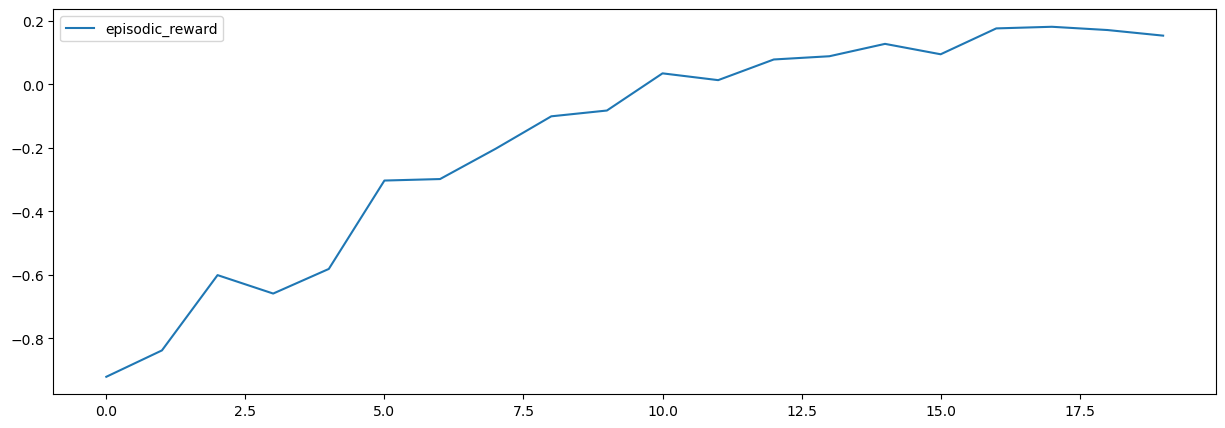

In [9]:
all_metrics = pd.DataFrame(history_metrics)
perc2float = lambda x: float(x.strip('%'))/100

all_metrics["Market Return"] = all_metrics["Market Return"].apply(perc2float)
all_metrics["Portfolio Return"] = all_metrics["Portfolio Return"].apply(perc2float)

all_metrics.plot(y=["episodic_reward"], figsize=(15, 5))
plt.show()

In [10]:
# Evaluate the agent on a new dataset from the same data generating process
returns = []
for i in range(10):
    x, y = nonstationaryDGP()
    spread = y - x
    _df = pd.DataFrame({'x': x, 'y': y, 'close': spread})
    _df = build_rolling_feature(_df, **feature_config)
    _df = _df.drop(columns=[f"feature_rolling_{i}" for i in range(1, 100)])
    
    env_test = gym.make("TradingEnv",
            name= "stationaryDGP",
            df = _df, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        )
    env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    env_test = agent.eval(env_test)
    returns.append(perc2float(env_test.unwrapped.get_metrics()["Portfolio Return"]))

print(f"Average Portfolio Return: {np.mean(returns)}")
print(f"Std Portfolio Return: {np.std(returns)}")

Market Return :  2.26%   |   Portfolio Return : -10.02%   |   Position Changes : 909   |   Episode Length : 10000   |   
Market Return : -0.94%   |   Portfolio Return : -7.29%   |   Position Changes : 949   |   Episode Length : 10000   |   
Market Return : -16.24%   |   Portfolio Return : -3.84%   |   Position Changes : 911   |   Episode Length : 10000   |   
Market Return : -25.35%   |   Portfolio Return : -12.68%   |   Position Changes : 909   |   Episode Length : 10000   |   
Market Return : 21.25%   |   Portfolio Return : -10.16%   |   Position Changes : 849   |   Episode Length : 10000   |   
Market Return : 12.42%   |   Portfolio Return : -10.32%   |   Position Changes : 939   |   Episode Length : 10000   |   
Market Return : -10.95%   |   Portfolio Return : -13.58%   |   Position Changes : 936   |   Episode Length : 10000   |   
Market Return : -1.09%   |   Portfolio Return : -9.27%   |   Position Changes : 985   |   Episode Length : 10000   |   
Market Return : -4.86%   |   Por